# Model distilBert1 train

Training of neural network classifier to fine-tune the DistilBert pretrained transformer model.

An embedding layer is defined by a sequence of 256 tokenized inputs and mask values. Then, only a simple pooling layer and a dense layer with 64 units that uses ReLU as activation function are added for the fine-tuning part of the model. An output layer uses a Softmax function to calculate the output probabilities over the classes.

In [1]:
import warnings
warnings.filterwarnings("ignore")
from transformers import logging as hf_logging
hf_logging.set_verbosity_error() # hide transformers library warning messages

import numpy as np
import os
import pickle
import pandas as pd
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


from trainevalutils import *
from tqdm import tqdm

In [2]:
MAX_LENGTH = 256

In [3]:
THIS_MODEL_NAME = 'distilBert'
VERSION = '1'


RESULT_DIR = '../results/'
OUTPUT_DIR = '../models/wip/'+THIS_MODEL_NAME+'/'
CHECKPOINTS_DIR = OUTPUT_DIR + 'checkpoints/'
MODEL_DIR = OUTPUT_DIR + THIS_MODEL_NAME + VERSION + '/'
HISTORY_DIR = OUTPUT_DIR + 'history/'
LOGS_DIR = OUTPUT_DIR + 'logs/'

for dir_ in [OUTPUT_DIR, CHECKPOINTS_DIR, MODEL_DIR, HISTORY_DIR, LOGS_DIR, RESULT_DIR]:
    if not os.path.exists(dir_):
        os.makedirs(dir_)

In [4]:
SEED = 3742
tf.random.set_seed(SEED)

class_names = pickle.load(open("../data/class_labels_dic.pkl", 'rb'))

TRANSFORMER_MODEL_NAME = 'distilbert-base-cased'

In [5]:
l = str(MAX_LENGTH)
X_train = pickle.load(open("../data/wip/dB/X_train_tot_"+l+".pkl", 'rb'))
y_train = pickle.load(open("../data/wip/dB/y_train_tot_"+l+".pkl", 'rb'))

X_val = pickle.load(open("../data/wip/dB/X_val_tot_"+l+".pkl", 'rb'))
y_val = pickle.load(open("../data/wip/dB/y_val_tot_"+l+".pkl", 'rb'))

In [7]:
def build_model(NUM_CLASSES):

    config = DistilBertConfig.from_pretrained(TRANSFORMER_MODEL_NAME, output_hidden_states=True, output_attentions=True)
    DistilBERT = TFDistilBertModel.from_pretrained(TRANSFORMER_MODEL_NAME, config=config)

    input_ids_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(MAX_LENGTH,), name='masked_token', dtype='int32') 

    embedding_layer = DistilBERT(input_ids = input_ids_in, attention_mask = input_masks_in)[0]

    # fine-tuning
    X = tf.keras.layers.GlobalMaxPool1D()(embedding_layer)
    X = tf.keras.layers.Dense(64, activation='relu')(X)

    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(X)

    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

    # Freezeing DistilBert layer
    # https://www.tensorflow.org/guide/keras/transfer_learning
    for layer in model.layers[:3]:
        layer.trainable = False

    return model

In [8]:
NUM_CLASSES = len(class_names)

model = build_model(NUM_CLASSES)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  65190912   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 256, 768),                                                   
                                 hidden_states=((No                                           

In [9]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINTS_DIR+'CHCKPNT-ep{epoch:02d}-vlos{val_loss:.2f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=1,
    verbose=1,
    min_delta=0.01,
    min_lr=0.000001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=False
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename = LOGS_DIR + 'training_log.csv',
    separator=',',
    append=True
)

# Calculate the class weights
class_weights = compute_class_weight('balanced', classes= np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(NUM_CLASSES)}

print("Class weights:", class_weights)

Class weights: {0: 0.4545195539839763, 1: 1.1477398655116995, 2: 1.3942740747527858, 3: 4.730862130814301}


## TRAIN

In [10]:
resuming_training = True
try:
    log = pd.read_csv(LOGS_DIR+'training_log.csv')
except FileNotFoundError:
    resuming_training = False
    log = pd.DataFrame({"epoch":[0]})
    print("Training starts from epoch 0.")

log

,epoch,accuracy,loss,lr,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0,0.823137,0.556354,0.0010,0.852250,0.796304,0.854456,0.401694,0.879528,0.834591
1,1,0.836461,0.515955,0.0010,0.860576,0.815553,0.838823,0.427692,0.865289,0.815137
2,2,0.845797,0.487380,0.0001,0.867941,0.826630,0.848154,0.398483,0.874166,0.825575
3,3,0.846368,0.484890,0.0001,0.867718,0.827927,0.852612,0.386807,0.874113,0.834276
4,4,0.846753,0.483552,0.0001,0.868022,0.828567,0.853264,0.381778,0.873918,0.836173
5,5,0.840056,0.504131,0.0010,0.862796,0.820606,0.858861,0.376452,0.887398,0.835303
6,6,0.842689,0.497630,0.0010,0.864948,0.823290,0.856508,0.378004,0.880563,0.836267
7,7,0.842263,0.497477,0.0010,0.864823,0.823079,0.855717,0.383467,0.890456,0.827293
8,8,0.843935,0.492730,0.0010,0.866529,0.824629,0.850091,0.393785,0.875224,0.828604
9,9,0.850247,0.471527,0.0001,0.872330,0.831660,0.853916,0.375282,0.876139,0.835267


In [11]:
## reload weighths if it's a retraining session
if resuming_training: 
    if len((os.listdir(MODEL_DIR))) == 0:
        checkpointName = input('Enter checkpoint file name: ')
        checkpoint = CHECKPOINTS_DIR + checkpointName
    else:
        checkpoint = MODEL_DIR
    model.load_weights(checkpoint)

In [12]:
METRICS = [tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.Precision(name='precision'),
           'accuracy'
          ]

OPTIMIZER = tf.keras.optimizers.Adam()

LOSS='categorical_crossentropy' #'sparse_categorical_crossentropy'

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [13]:
y_train_1hot = tf.one_hot(y_train, NUM_CLASSES)
y_val_1hot = tf.one_hot(y_val, NUM_CLASSES)

### TRAIN

In [19]:
MAX_EPOCHS = 10
BATCH_SIZE = 64

initial_epoch = log["epoch"].iloc[-1:].values[0]
if resuming_training: initial_epoch += 1


history = model.fit(X_train, 
                    y_train_1hot, 
                    epochs = MAX_EPOCHS, initial_epoch=initial_epoch,
                    batch_size = BATCH_SIZE, 
                    validation_data=(X_val, y_val_1hot), 
                    callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                    class_weight=class_weights
                   )


model.save_weights(MODEL_DIR)

with open(HISTORY_DIR+'history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 8/10
21623/24728 [=========================>....] - ETA: 11:03 - loss: 0.4978 - recall: 0.8229 - precision: 0.8647 - accuracy: 0.8421

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 8: val_loss improved from inf to 0.38347, saving model to ../models/wip/distilBert/checkpoints/CHCKPNT-ep08-vlos0.38.hdf5
24728/24728 [==============================] - 6066s 245ms/step - loss: 0.4975 - recall: 0.8231 - precision: 0.8648 - accuracy: 0.8423 - val_loss: 0.3835 - val_recall: 0.8273 - val_precision: 0.8905 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 9/10
24728/24728 [==============================] - ETA: 0s - loss: 0.4927 - recall: 0.8246 - precision: 0.8665 - accuracy: 0.8439
Epoch 9: val_loss did not improve from 0.38347

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
24728/24728 [==============================] - 6062s 245ms/step - loss: 0.4927 - recall: 0.8246 - precision: 0.8665 - accuracy: 0.8439 - val_loss: 0.3938 - val_recall: 0.8286 - val_precision: 0.8752 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 10/10
24728/24728 [==============================] - ETA: 0s - loss: 0.4715 - recall: 0.8317 - precision: 0.8723 - accuracy: 0.8502
E

Highest Validation Precision: epoch 8
Highest Validation Recall: epoch 7
Highest Validation Accuracy: epoch 6
Lowest Validation Loss: epoch 10


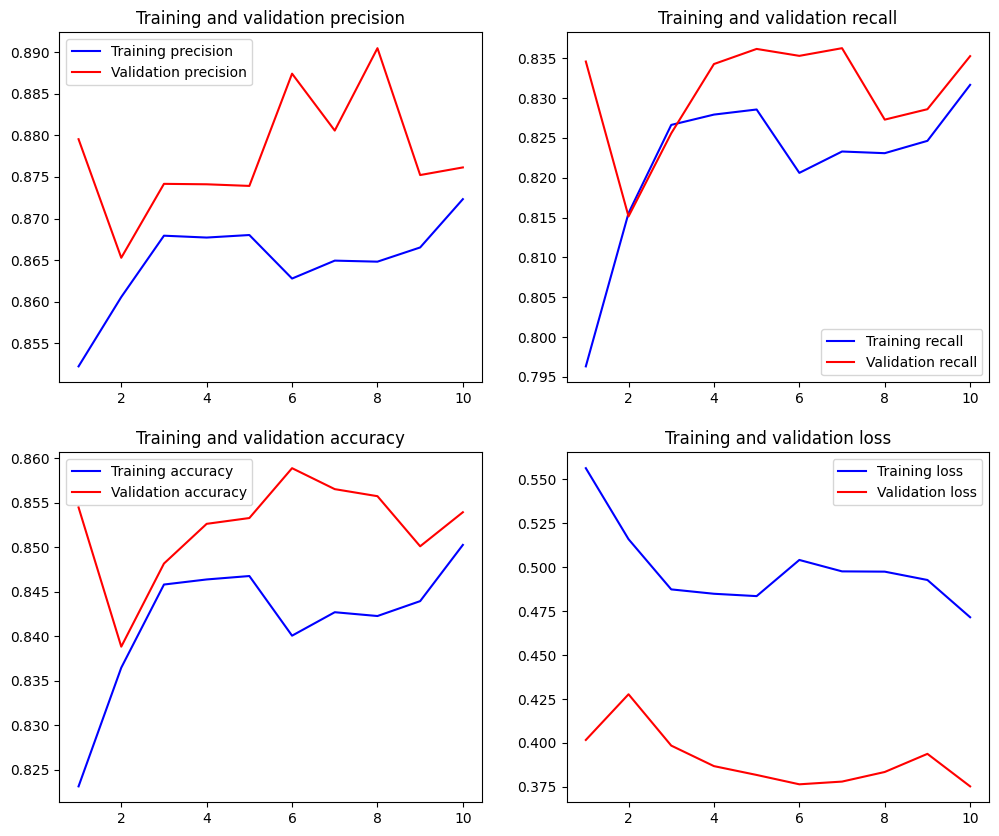

In [25]:
def load_history():
    if resuming_training:
        log = pd.read_csv(LOGS_DIR+'training_log.csv')
        data_dict = log.drop("epoch", axis=1).to_dict()
        output_dict = {}
        for key in data_dict.keys():
            output_dict[key] = list(data_dict[key].values())
        return output_dict
    return history.history

history_dict = load_history()
plot_history(history_dict)

### Selection of epoch to use for evaluation
The model to evaluate can be loaded from a previous epoch, if required after the history plot analysis.

In [ ]:
# if needed, reload a model from a previous checkpoint file.
checkpointName = input('Enter checkpoint file name: ')
checkpoint = CHECKPOINTS_DIR + checkpointName
model.load_weights(checkpoint)

In [14]:
def evaluate_nn(name, X, y_actual):
    y_probs = model.predict(X)

    y_pred = []
    for prob in y_probs:
        y_pred.append(np.argmax(prob))

    res = generate_model_report(name, y_actual, y_pred)

    report = metrics.classification_report(y_actual, y_pred, target_names=target_names.values())
    print(f'\nClassification report:\n{report}')
    return res

In [15]:
result_train = evaluate_nn(THIS_MODEL_NAME+VERSION+'_train', X_train, y_train)

49456/49456 [==============================] - 4599s 93ms/step
Accuracy: 0.853869786321978
Precision (macro): 0.7535836888732896
Recall (macro): 0.8127038386918176
F1-score (macro): 0.7642925213509699

Classification report:
              precision    recall  f1-score   support

     Physics       0.97      0.90      0.93    870462
 Mathematics       0.83      0.87      0.85    344714
Computer Sc.       0.85      0.73      0.79    283762
       Other       0.36      0.75      0.49     83630

    accuracy                           0.85   1582568
   macro avg       0.75      0.81      0.76   1582568
weighted avg       0.89      0.85      0.87   1582568



In [17]:
result_val = evaluate_nn(THIS_MODEL_NAME+VERSION+'_val', X_val, y_val)

8728/8728 [==============================] - 812s 93ms/step
Accuracy: 0.8539335498447778
Precision (macro): 0.7540600465899808
Recall (macro): 0.8128564784614455
F1-score (macro): 0.7645363856227644

Classification report:
              precision    recall  f1-score   support

     Physics       0.97      0.90      0.93    153261
 Mathematics       0.83      0.87      0.85     60818
Computer Sc.       0.85      0.73      0.79     50476
       Other       0.36      0.75      0.49     14722

    accuracy                           0.85    279277
   macro avg       0.75      0.81      0.76    279277
weighted avg       0.89      0.85      0.87    279277



In [18]:
df_result = pd.DataFrame([result_val])
df_result

,Description,Accuracy,Precision,Recall,F1-score
0,distilBert1_val,0.853934,0.75406,0.812856,0.764536


In [19]:
df_result.to_pickle(RESULT_DIR+'results_'+THIS_MODEL_NAME+VERSION+'.pkl')